In [1]:
import os
import numpy as np

import keras
from keras import losses
from keras import metrics
import keras.backend as K
from keras import initializers
from keras import regularizers
from keras.datasets import mnist
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, Lambda  
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D 

import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
import random
import cv2

Using TensorFlow backend.


Before you begin, there will a lot of text for description but don't let that scare you. 
Longer description => more detail, that's all!

(More bluntly, hold off extensions requests till the last 3 days at least please)

# PART 2 - DCGAN

The first part of this assignment is coding up a DCGAN structure, this is a fairly standard network that you can look up online. 

This is an open ended part, you can look up the structure online and code and implement it with the functional API in Keras. It will involve setting up 3 primary things: 

There is no exactly correct network, as long as the network and code is correct, your hyperparameters are not important to your marks.

1. Adding the model structure generator 
2. Adding the model structure for the discriminator
3. Compling both models
4. Creating the training loop

The training loop in particular will be very different from what you're used to in previous assignments. 

https://towardsdatascience.com/understanding-generative-adversarial-networks-4dafc963f2ef

Use this as a useful resource to figure out how to set up the training loop, go over this blog, feel free to look at the code.

BUT BEFORE YOU RIP OFF THE CODE FROM THIS RESOURCE, bear in mind that this is for a GAN and not a DCGAN, we expect a GAN :) 

In [16]:
width = 28
height = 28
channels = 3
noise_dim = 10
shape = (28, 28, 3)
optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

In [17]:
def generator():
# All weights were initialized from a zero-centered Normal distribution with SD 0.02
    inp = Input(shape=(noise_dim,))
    dense = Dense(7*7*64)(inp)
    reshape = Reshape((7,7,64))(dense)
    batch_norm = BatchNormalization()(reshape)
    activation = Activation('relu', name = 'relu_activation1')(batch_norm)

    trans_conv2D = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(activation)
    batch_norm = BatchNormalization()(trans_conv2D)
    activation = Activation('relu', name = 'relu_activation2')(batch_norm)

    trans_conv2D = Conv2DTranspose(3, kernel_size=3, strides=2, padding='same')(activation)
    activation = Activation('tanh', name = 'tanh_activation')(trans_conv2D)

    model = Model(inputs= inp, outputs= activation)
    return model

def discriminator():
    inp = Input(shape=shape)
    activation = LeakyReLU(alpha=0.2)(inp)
    
    conv2D = Conv2D(32, kernel_size=3, strides=2, padding='same')(activation)
    batch_norm = BatchNormalization()(conv2D)
    activation = LeakyReLU(alpha=0.2)(batch_norm)
    
    
    conv2D = Conv2D(64, kernel_size=3, strides=2, padding='same')(activation)
    batch_norm = BatchNormalization()(conv2D)
    activation = LeakyReLU(alpha=0.2)(batch_norm)
    
    flat = Flatten()(activation)
    dense = Dense(1, activation= 'sigmoid')(flat)
    
    model = Model(inputs= inp, outputs= dense)
    return model

In [18]:
G = generator()
G.compile(loss='binary_crossentropy', optimizer=optimizer)
D = discriminator()
D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

dcgan = Sequential([G, D])
dcgan.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=optimizer)

In [5]:
print ("Generator Summary")
G.summary()
print ("\n\nDiscriminator Summary")
D.summary()
print ("\n\nDCGAN Summary")
dcgan.summary()


Generator Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
relu_activation1 (Activation (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128

In [6]:
def make_trainable(model, mode):
    for layer in model.layers:
        layer.trainable = mode
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
def gen_random_sample(sample_size=32):
    rand = np.random.normal(0, 1, size =(sample_size,10))
    return rand

In [7]:
def preprocess(x):    
    x = np.float64(x)
    x = (x / 255)
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x * 255)
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    return x

In [8]:
num_of_training_images = 850
num_of_eval_images = 220

images_dir = 'train/'
image_paths = os.listdir(images_dir)
for i in range(len(image_paths)):
    image_paths[i] = images_dir + image_paths[i]
image_paths = image_paths[0:162] + image_paths[163:] 

train_image_paths = image_paths[0:num_of_training_images]
eval_image_paths = image_paths[num_of_training_images: num_of_training_images+num_of_eval_images]

training_images_real = np.zeros(shape=(num_of_training_images,28,28,3))
eval_images_real =  np.zeros(shape=(num_of_eval_images,28,28,3))

for i in range(len(training_images_real)):
    x = cv2.imread(train_image_paths[i])
    training_images_real[i] = cv2.resize(x,(28,28))  
for i in range(len(eval_images_real)):
    eval_images_real[i] = cv2.resize(cv2.imread(eval_image_paths[i]),(28,28))

training_images_real = preprocess(training_images_real)
eval_images_real = preprocess(eval_images_real)
    

In [9]:
## ADD Code to Train DCGAN
def train_gan(epochs=2, batch_size=128, eval_size=32):    
    losses = []
    for e in range(epochs):
        for i in range(len(training_images_real)//batch_size):       
            batch_x_real = training_images_real[i*batch_size:(i+1)*batch_size]

            random_noise = gen_random_sample(batch_size)
            batch_x_fake = G.predict_on_batch(random_noise)

            batch_y_real = np.ones(shape=(batch_size,))
            batch_y_fake = np.zeros(shape=(batch_size,))

            make_trainable(D, True)
            D.train_on_batch(batch_x_real, batch_y_real*(0.9))
            D.train_on_batch(batch_x_fake, batch_y_fake)

            make_trainable(D, False)
            dcgan.train_on_batch(random_noise, batch_y_real)

        #evaluation
        x_eval_real = eval_images_real[np.random.choice(len(eval_images_real), eval_size, replace=False)]
        random_noise = gen_random_sample(eval_size)
        x_eval_fake = G.predict_on_batch(random_noise)

        y_eval_real = np.ones(shape=(eval_size,))
        y_eval_fake = np.zeros(shape=(eval_size,))

        d_loss = D.test_on_batch(x_eval_real,y_eval_real)
        d_loss += D.test_on_batch(x_eval_fake,y_eval_fake)
        g_loss = dcgan.test_on_batch(random_noise, y_eval_real)

        losses.append((d_loss,g_loss))

        print("Epoch: " + str(e+1) + "/" + str(epochs) + " Discriminator Loss: " 
                  + str(d_loss[0]) + " Generator Loss: " + str(g_loss[0]))


In [19]:
## Save Generator and discriminator models
G.save('generator.h5')
D.save('degenator.h5')
dcgan.save('dcgan.h5')

In [12]:
# TRAIN YOUR DCGAN for exactly 2 EPOCHS here.
train_gan(epochs=2)
# For those more adventerous you can copy your code to Collab and actually train a model for 
# more EPOCHS to see how well it trains and test it with better results (recommended).

Epoch: 1/2 Discriminator Loss: 0.11720322 Generator Loss: 0.04699552
Epoch: 2/2 Discriminator Loss: 0.34255534 Generator Loss: 0.07006073


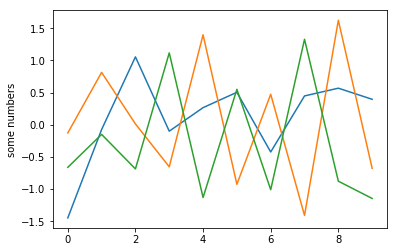

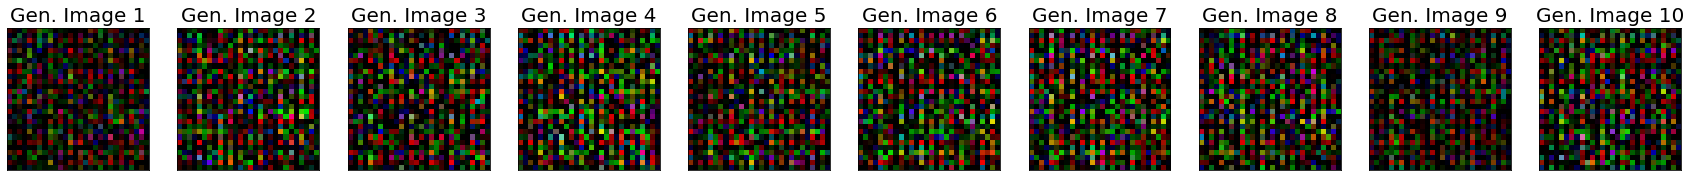

In [15]:
# ADD Code to Generate a sample images and visualize them. 
# Doesn't matter if your network didn't get anywhere in 2 EPOCHS, we're only checking your code not your results
# Sample generation of noise vector
samples = 10

import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (samples, noise_dim))
plt.plot(noise[0:3].T)
plt.ylabel('some numbers')
plt.show()

gen_images = G.predict(noise)
gen_images = deprocess(gen_images)
plt.figure(figsize=(30,10))
n = samples
for i in range(n): 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(gen_images[i])
    plt.title('Gen. Image '+ str(i+1), size=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Report

In your own words, summarize the model training process, how do the generator and the discriminator train together?